In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from collections import Counter

# **Utility functions**

In [2]:
def compute_m_t(element,bids):
  temp = bids.copy()
  temp.remove(element)
  temp.sort()
  return temp[-1]

In [3]:
def compute_weights(rho, rewards, costs):
  l = len(rewards)
  c = (-rewards).tolist() # declare coefficients of the objective function
  A_in = [costs.tolist()] # declare the inequality constraint matrix
  b_in = [rho] # declare the inequality constraint vector
  A_e = [np.ones(l)] # declare the equality constraint matrix
  b_e = [1] # declare the equality constraint vector
  results = linprog(c=c, A_ub=A_in, b_ub=b_in, A_eq=A_e, b_eq=b_e, method='highs-ds')   # solve
  return results.x

In [4]:
def extract_winners(placement, p, lst):
  p_history = []
  for item in lst:
    if p in item and item.index(p) == (placement-1): #Placement = 1 is first place, Placement = 2 is second place
      p_history.append(1)
    else:
      p_history.append(0)
  return p_history

# **Auction**

In [5]:
class Auction:
    def __init__(self, *args, **kwargs):
        pass

    def get_winners(self, bids):
        pass

    def get_payments_per_click(self, winners, values, bids):
        pass

    def round(self, bids):
        winners, values = self.get_winners(bids) # allocation mechanism!
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click

In [6]:
class GeneralizedFirstPriceAuction(Auction):
    def __init__(self, ctrs, valuations):
        self.ctrs = ctrs
        self.valuations = valuations
        self.n_adv = len(self.ctrs)
        self.n_slots = len(self.valuations)

    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winner = adv_ranking[-self.n_slots:]
        winner = np.flip(winner)
        return winner, adv_values #Reverse winners to get in position 0 the winner, position 1 the second place ...

    def get_payments_per_click(self, winners, values, bids):
        payment = []
        for element in winners:
          if bids[element] > 0:
            payment.append(bids[element])
          else:
            payment.append(0)
        return payment

# **Multiplicative Pacing (Primal Dual for Truthful Auctions)**

In [7]:
class MultiplicativePacingAgent:
    def __init__(self, bids_set, valuations, budget, T, eta):
        self.bids_set = bids_set #Need to discretize the bids
        self.valuations = valuations
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 0
        self.t = 0
        self.budget_depleted = False

    def bid(self):
        if self.budget < 1:
            self.budget_depleted = True
            return -1 # ---> never winning the auction

        con_bid = self.valuations[0]/(self.lmbd+1) # Scaled continuos bid
        #return con_bid

        #Discrete bid: since other regret minimizers have discrete set of bid, we impose this also to MPAgent by choosing the closest bid
        return min(self.bids_set, key=lambda x:abs(x-con_bid))

    def update(self, f_t, c_t):
        if self.budget_depleted == False:
          self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t),
                              a_min=0, a_max=1/self.rho)
          #Update the lambda
          self.budget -= c_t
        else:
          pass

    def get_budget_depleted(self):
      return self.budget_depleted

# **Generalized Multiplicative Pacing (Primal Dual for Non-Truthful Auctions)**

In [8]:
class HedgeAgent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.x_t = np.ones(K)/K
        self.a_t = None
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t

    def update(self, l_t):
        self.weights *= np.exp(-self.learning_rate*l_t)
        self.t += 1

In [9]:
class FFMultiplicativePacingAgent:
    def __init__(self, bids_set, valuations, budget, T, eta):
        self.bids_set = bids_set
        self.K = len(bids_set)
        self.hedge = HedgeAgent(self.K, np.sqrt(np.log(self.K)/T))
        self.valuations = valuations
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0
        self.budget_depleted = False

    def bid(self):
        if self.budget < 1:
            self.budget_depleted = True
            return -1 # ---> never winning the auction
        return self.bids_set[self.hedge.pull_arm()]

    def update(self, f_t, c_t, m_t):
        if self.budget_depleted == False:
          # update hedge
          f_t_full = np.array([(self.valuations[0]-b)*int(b >= m_t) for b in self.bids_set])
          c_t_full = np.array([b*int(b >= m_t) for b in self.bids_set])
          L = f_t_full - self.lmbd*(c_t_full-self.rho)
          range_L = 2+(1-self.rho)/self.rho
          self.hedge.update((2-L)/range_L) # hedge needs losses in [0,1]
          # update lagrangian multiplier
          self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t), a_min=0, a_max=1/self.rho)
          # update budget
          self.budget -= c_t
        else:
          pass

    def get_budget_depleted(self):
      return self.budget_depleted

# **UCB-like Agent**

In [10]:
class UCB1Agent:
    def __init__(self, bids_set,valuations, budget, T, range=1):

        self.bids_set = bids_set
        self.K = len(bids_set)
        self.T = T
        self.range = range

        self.a_t = None
        self.average_rewards = np.zeros(self.K)
        self.average_costs = np.zeros(self.K)
        self.N_pulls = np.zeros(self.K)
        self.t = 0

        self.budget = budget
        self.valuations = valuations
        self.rho = self.budget/self.T

        self.budget_depleted = False

    def bid(self):
      if self.budget < 1:
            self.budget_depleted = True
            return -1 # ---> never winning the auction
      else:
        if self.t < self.K:
            self.a_t = (self.t) / (self.K-1) #rescaled bid
        else:
            ucbs_rewards = self.average_rewards + self.range*np.sqrt(2*np.log(self.t)/self.N_pulls) #can also use self.T instead of self.t
            ucbs_costs = self.average_costs - self.range*np.sqrt(2*np.log(self.t)/self.N_pulls) #can also use self.T instead of self.t

            weights = compute_weights(self.rho, ucbs_rewards, ucbs_costs) #Compute the weights using linear program
            self.a_t = np.random.choice(np.arange(self.K), p=weights) / (self.K-1) #Sample an arm from the distribution obtained through weights
        return self.a_t

    def update(self, r_t, c_t):
        if self.budget_depleted == False:
          index = int(self.a_t*(self.K-1))

          self.N_pulls[index] += 1
          self.average_rewards[index] += (r_t - self.average_rewards[index])/self.N_pulls[index]
          self.average_costs[index] += (c_t - self.average_costs[index])/self.N_pulls[index]

          self.t += 1
          self.budget -= c_t
        else:
          pass

    def get_budget_depleted(self):
      return self.budget_depleted

# **Competition among algorithms step by step**

## Parameters

In [11]:
player_types_name = ["MP Agent", "FFMP Agent", "UCB Agent"]
player_types = len(player_types_name)

n_player_per_type = 1 #change this to increase competition!
n_advertisers = player_types * n_player_per_type

ctrs = np.ones(n_advertisers)
my_valuations = [0.8, 0.8] #can change this to build more complex environments
B = 1000
n_users = 5000

eta = 1/np.sqrt(n_users)

n_arms = 11 #change this to increse/decrese the number of arms
available_bids = np.linspace(0,1,n_arms)

print_rounds = False
seed = 100

## Interaction

In [12]:
players = []

#initialize players and auction
for i in range(n_player_per_type):
  MP_Agent = MultiplicativePacingAgent(bids_set=available_bids, valuations=my_valuations, budget=B, T=n_users, eta=eta)
  FFMP_Agent = FFMultiplicativePacingAgent(bids_set=available_bids, valuations=my_valuations, budget=B, T=n_users, eta=eta)
  UCB1_Agent = UCB1Agent(bids_set=available_bids,valuations=my_valuations, budget=B, T=n_users)

  players.append(MP_Agent)
  players.append(FFMP_Agent)
  players.append(UCB1_Agent)

auction = GeneralizedFirstPriceAuction(ctrs, my_valuations)

#initialize arrays for logging
utilities_array = [[] for _ in range(n_advertisers)]
bids_array = [[] for _ in range(n_advertisers)]
payments_array = [[] for _ in range(n_advertisers)]
winners_history = []

budget_depleted_array = [[] for _ in range(n_advertisers)]

total_first_place_array = [0] * n_advertisers
total_second_place_array = [0] * n_advertisers

#array for checking if everyone has depleted his budget
#if players[i] has depleted his budget -> budgets_flag[i] = 1
budgets_flag = [0] * n_advertisers

np.random.seed(seed)

#start interaction
for u in range(n_users):
    bids = [] #this is used for allocation
    bids_normalized = [] #this is used to for coherence with what actually happen (bid = -1 ---> bid = 0)

    #player select their bid
    for i in range(n_advertisers):

      bid = round(players[i].bid(),2)
      bids.append(bid)

      #logging bids for each player
      if bid > 0:
        bids_array[i].append(bid)
        bids_normalized.append(bid)
      else:
        bids_array[i].append(0)
        bids_normalized.append(0)

      #logging info about budget depletion
      budget_depleted_array[i].append(players[i].get_budget_depleted())

    #check who are the winners
    winners, payments_per_click = auction.round(bids=bids)
    #if the second place is a bidder with no budget --> no one gets the second slot
    if budget_depleted_array[winners[1]][u] == True:
      winners[1] = -1

    winners_history.append(list(winners))

    #update players and log
    for j in range(n_advertisers):
      if j in winners:
        index_winner = list(winners).index(j)

        f_t, c_t = (my_valuations[index_winner]-payments_per_click[index_winner]), payments_per_click[index_winner]

        if index_winner == 0 and budget_depleted_array[j][u] == False:
          total_first_place_array[j] += 1
        elif index_winner == 1 and budget_depleted_array[j][u] == False:
          total_second_place_array[j] += 1
      else:
        f_t, c_t = 0, 0

      if isinstance(players[j], FFMultiplicativePacingAgent):
        m_t = compute_m_t(bids[j], bids)
        players[j].update(f_t, c_t, m_t)
      else:
        players[j].update(f_t, c_t)

      #check if players have depleted their budget
      if players[j].budget < 1:
        budgets_flag[j] = 1

      # logging
      utilities_array[j].append(f_t)
      payments_array[j].append(c_t)

    #print the round
    if print_rounds == True:
      print(f'Round {u+1}) --- Bids: {bids_normalized} --- Winners: {winners} --- payment: {payments_per_click}')

    # Check if everyone is out of budget: if yes -> stop the rounds
    flag = 1
    for i in budgets_flag:
      flag = flag*i
    if flag == 1:
      break

#Print some results
print(f'Total # of interactions: {u+1}')
for i in range(n_advertisers):
  print(f'Total # of First Places of player {player_types_name[i%3]} {int(i/3) + 1}: {total_first_place_array[i]}')
  print(f'Total # of Second Places of player {player_types_name[i%3]} {int(i/3) + 1}: {total_second_place_array[i]}')

Total # of interactions: 4753
Total # of First Places of player MP Agent 1: 670
Total # of Second Places of player MP Agent 1: 2513
Total # of First Places of player FFMP Agent 1: 2034
Total # of Second Places of player FFMP Agent 1: 1039
Total # of First Places of player UCB Agent 1: 2049
Total # of Second Places of player UCB Agent 1: 666


## Plots

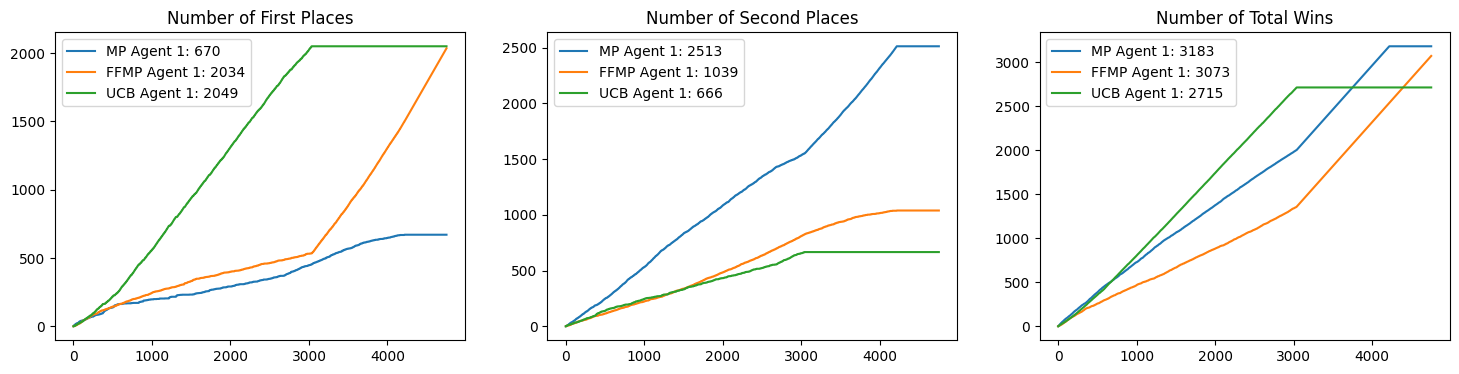

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (18,4))
for i in range(n_advertisers):
  axes[0].plot(np.array(extract_winners(1,i,winners_history)).cumsum(), label=f'{player_types_name[i%3]} {int(i/3) + 1}: {total_first_place_array[i]}')
  axes[1].plot(np.array(extract_winners(2,i,winners_history)).cumsum(), label=f'{player_types_name[i%3]} {int(i/3) + 1}: {total_second_place_array[i]}')
  axes[2].plot((np.array(extract_winners(1,i,winners_history)) + np.array(extract_winners(2,i,winners_history))).cumsum(), label=f'{player_types_name[i%3]} {int(i/3) + 1}: {total_first_place_array[i] + total_second_place_array[i]}')

axes[0].set_title('Number of First Places')
axes[0].legend()
axes[1].set_title('Number of Second Places')
axes[1].legend()
axes[2].set_title('Number of Total Wins')
axes[2].legend()

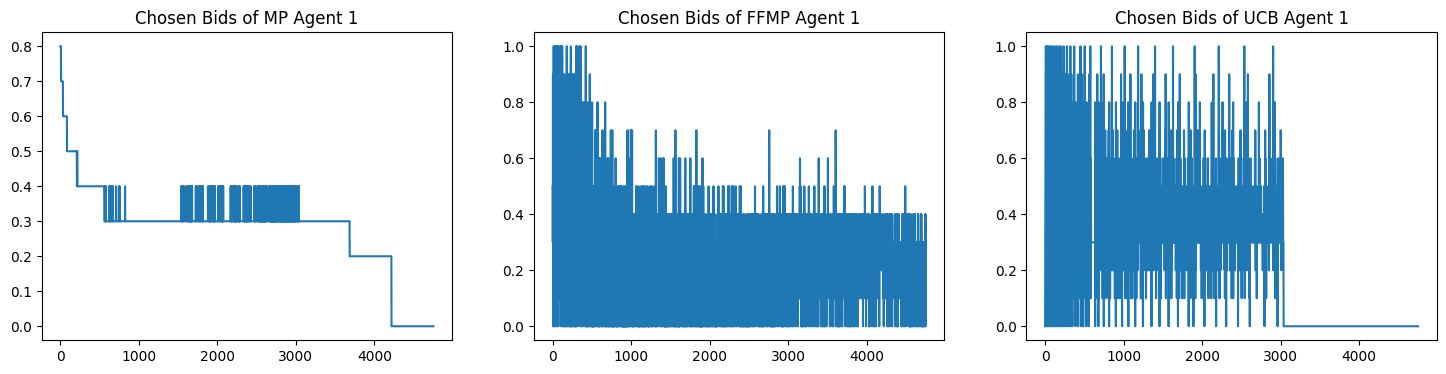

In [14]:
fig, axes = plt.subplots(nrows=n_player_per_type, ncols=player_types, figsize = (player_types*6,n_player_per_type*4))
axes = axes.reshape((-1,))

for i in range(n_advertisers):
  axes[i].plot(bids_array[i])
  axes[i].set_title(f'Chosen Bids of {player_types_name[i%3]} {int(i/3) + 1}')

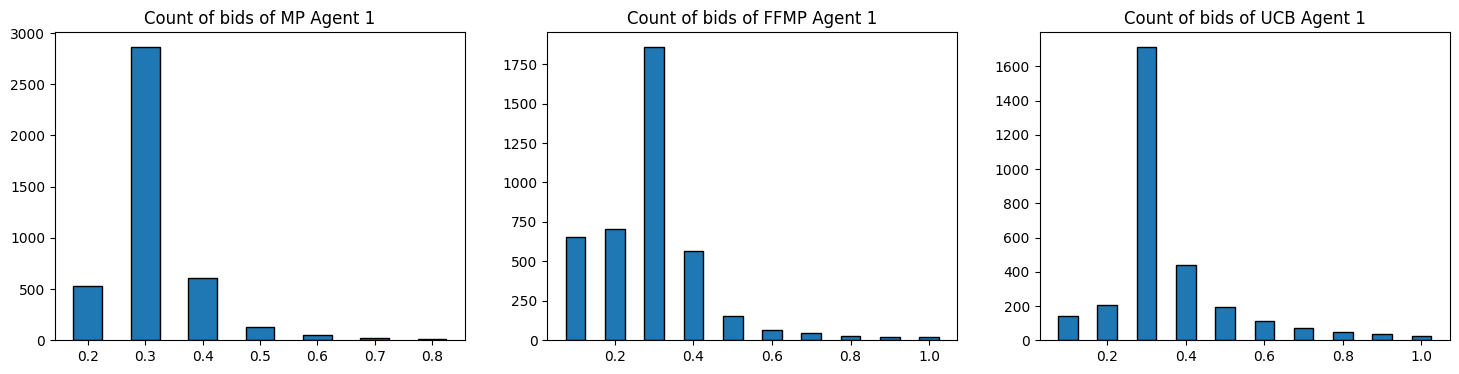

In [15]:
fig, axes = plt.subplots(nrows=n_player_per_type, ncols=player_types, figsize = (player_types*6,n_player_per_type*4))
axes = axes.reshape((-1,))
for i in range(n_advertisers):
  #data = bids_array[i]
  data = [elem for elem in bids_array[i] if elem != 0] #drop bids=0 (no bid)

  data_keys = Counter(data).keys()
  data_values = Counter(data).values()

  axes[i].bar(data_keys,data_values,edgecolor='black',width=0.05)
  axes[i].set_title(f'Count of bids of {player_types_name[i%3]} {int(i/3) + 1}')

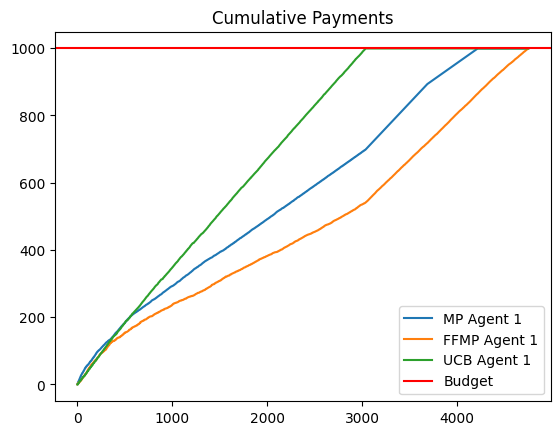

In [16]:
for i in range(n_advertisers):
  cumulative_payments = np.cumsum(payments_array[i])
  plt.plot(cumulative_payments,label=f'{player_types_name[i%3]} {int(i/3) + 1}')
  plt.title('Cumulative Payments')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.show()

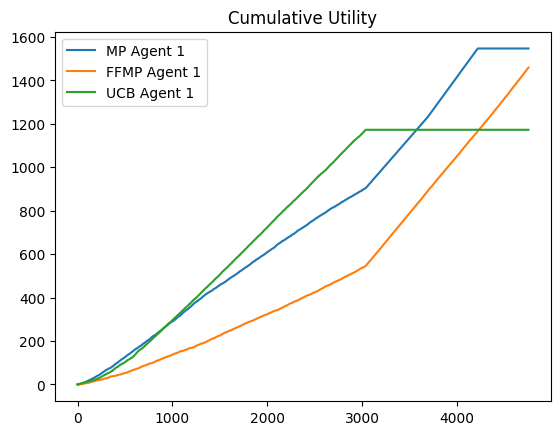

In [17]:
for i in range(n_advertisers):
  cumulative_utilities = np.cumsum(utilities_array[i])
  plt.plot(cumulative_utilities,label=f'{player_types_name[i%3]} {int(i/3) + 1}')
  plt.title('Cumulative Utility')
plt.legend()
plt.show()

# **Try different parameters**

## Trial Class

In [18]:
class Trial:
  def __init__(self, n_player_per_type=1, my_valuations=[0.8, 0.8], B=1000, n_users=5000, n_arms=11, print_rounds=False, seed=100):
    self.player_types_name = ["MP Agent", "FFMP Agent", "UCB Agent"]
    self.player_types = len(self.player_types_name)

    self.n_player_per_type = n_player_per_type
    self.my_valuations = my_valuations
    self.B = B
    self.n_users = n_users
    self.n_arms = n_arms

    self.n_advertisers = self.player_types * self.n_player_per_type

    self.ctrs = np.ones(self.n_advertisers)
    self.eta = 1/np.sqrt(self.n_users)
    self.available_bids = np.linspace(0,1,self.n_arms)
    self.print_rounds = print_rounds
    self.seed = seed

    self.players = []

    #initialize players and auction
    for i in range(self.n_player_per_type):
      MP_Agent = MultiplicativePacingAgent(bids_set=self.available_bids, valuations=self.my_valuations, budget=self.B, T=self.n_users, eta=self.eta)
      FFMP_Agent = FFMultiplicativePacingAgent(bids_set=self.available_bids, valuations=self.my_valuations, budget=self.B, T=self.n_users, eta=self.eta)
      UCB1_Agent = UCB1Agent(bids_set=self.available_bids, valuations=self.my_valuations, budget=self.B, T=self.n_users)

      self.players.append(MP_Agent)
      self.players.append(FFMP_Agent)
      self.players.append(UCB1_Agent)

    self.auction = GeneralizedFirstPriceAuction(self.ctrs, self.my_valuations)

    #initialize arrays for logging
    self.utilities_array = [[] for _ in range(self.n_advertisers)]
    self.bids_array = [[] for _ in range(self.n_advertisers)]
    self.payments_array = [[] for _ in range(self.n_advertisers)]
    self.winners_history = []

    self.budget_depleted_array = [[] for _ in range(self.n_advertisers)]

    self.total_first_place_array = [0] * self.n_advertisers
    self.total_second_place_array = [0] * self.n_advertisers

    #array for checking if everyone has depleted his budget
    #if players[i] has depleted his budget -> budgets_flag[i] = 1
    self.budgets_flag = [0] * self.n_advertisers

    np.random.seed(self.seed)

    #start interaction
    for u in range(self.n_users):
        bids = [] #this is used for allocation
        bids_normalized = [] #bid = -1 --> bid = 0

        #player select their bid
        for i in range(self.n_advertisers):

          bid = round(self.players[i].bid(),2)
          bids.append(bid)

          #logging bids for each player
          if bid > 0:
            self.bids_array[i].append(bid)
            bids_normalized.append(bid)
          else:
            self.bids_array[i].append(0)
            bids_normalized.append(0)

          #logging info about budget depletion
          self.budget_depleted_array[i].append(self.players[i].get_budget_depleted())

        #check who are the winners
        winners, payments_per_click = self.auction.round(bids=bids)
        #if the second place is a bidder with no budget --> no one gets the second slot i.e. winner is player -1
        if self.budget_depleted_array[winners[1]][u] == True:
          winners[1] = -1

        self.winners_history.append(list(winners))

        #update players and log
        for j in range(self.n_advertisers):
          if j in winners:
            index_winner = list(winners).index(j)
            f_t, c_t = (self.my_valuations[index_winner]-payments_per_click[index_winner]), payments_per_click[index_winner]
            #Update first and second places array (only if player has not depleted the budget yet)
            if index_winner == 0 and self.budget_depleted_array[j][u] == False:
              self.total_first_place_array[j] += 1
            elif index_winner == 1 and self.budget_depleted_array[j][u] == False:
              self.total_second_place_array[j] += 1
          else:
            f_t, c_t = 0, 0

          if isinstance(self.players[j], FFMultiplicativePacingAgent):
            m_t = compute_m_t(bids[j], bids)
            self.players[j].update(f_t, c_t, m_t)
          else:
            self.players[j].update(f_t, c_t)

          #check if players have depleted their budget
          if self.players[j].budget < 1:
            self.budgets_flag[j] = 1

          # logging
          self.utilities_array[j].append(f_t)
          self.payments_array[j].append(c_t)

        #print the round
        if self.print_rounds == True:
          print(f'Round {u+1}) --- Bids: {bids_normalized} --- Winners: {winners} --- payment: {payments_per_click}')

        # Check if everyone is out of budget: if yes --> stop the rounds
        flag = 1
        for i in self.budgets_flag:
          flag = flag*i
        if flag == 1:
          break

    #final print
    print(f'Total # of interactions: {u+1}')


  def print_results(self):
    for i in range(self.n_advertisers):
      print(f'Total # of First Places of player {self.player_types_name[i%3]} {int(i/3) + 1}: {self.total_first_place_array[i]}')
      print(f'Total # of Second Places of player {self.player_types_name[i%3]} {int(i/3) + 1}: {self.total_second_place_array[i]}')


  def plot_winnings(self):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (18,4))
    for i in range(self.n_advertisers):
      axes[0].plot(np.array(extract_winners(1,i,self.winners_history)).cumsum(), label=f'{self.player_types_name[i%3]} {int(i/3) + 1}: {self.total_first_place_array[i]}')
      axes[1].plot(np.array(extract_winners(2,i,self.winners_history)).cumsum(), label=f'{self.player_types_name[i%3]} {int(i/3) + 1}: {self.total_second_place_array[i]}')
      axes[2].plot((np.array(extract_winners(1,i,self.winners_history)) + np.array(extract_winners(2,i,self.winners_history))).cumsum(), label=f'{self.player_types_name[i%3]} {int(i/3) + 1}: {self.total_first_place_array[i] + self.total_second_place_array[i]}')
    axes[0].set_title('Number of First Places')
    axes[0].legend()
    axes[1].set_title('Number of Second Places')
    axes[1].legend()
    axes[2].set_title('Number of Total Wins')
    axes[2].legend()


  def plot_payments_and_utilities(self):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (12,4))
    for i in range(self.n_advertisers):
      cumulative_payments = np.cumsum(self.payments_array[i])
      axes[0].plot(cumulative_payments,label=f'{self.player_types_name[i%3]} {int(i/3) + 1}')
      cumulative_utilities = np.cumsum(self.utilities_array[i])
      axes[1].plot(cumulative_utilities,label=f'{self.player_types_name[i%3]} {int(i/3) + 1}')
    axes[0].set_title('Cumulative Payments')
    axes[0].axhline(self.B, color='red', label='Budget')
    axes[0].legend()
    axes[1].set_title('Cumulative Utilities')
    axes[1].legend()


  def plot_biddings(self):
    #Plor history of bids
    fig, axes = plt.subplots(nrows=self.n_player_per_type, ncols=self.player_types, figsize = (self.player_types*6,self.n_player_per_type*4))
    axes = axes.reshape((-1,))
    for i in range(self.n_advertisers):
      #data = bids_array[i]
      data = [elem for elem in self.bids_array[i] if elem != 0] #drop bids=0 (no bid)
      data_keys = Counter(data).keys()
      data_values = Counter(data).values()
      axes[i].bar(data_keys,data_values,edgecolor='black',width=0.05)
      axes[i].set_title(f'Count of bids of {self.player_types_name[i%3]} {int(i/3) + 1}')

    #Plot chosen bids
    fig, axes = plt.subplots(nrows=self.n_player_per_type, ncols=self.player_types, figsize = (self.player_types*6,self.n_player_per_type*4))
    axes = axes.reshape((-1,))
    for i in range(self.n_advertisers):
      axes[i].plot(self.bids_array[i])
      axes[i].set_title(f'Chosen Bids of {self.player_types_name[i%3]} {int(i/3) + 1}')


## Default Trial

*   n_player_per_type = 1
*   my_evaluation = [0.8, 0.8]
*   B = 1000
*   n_users = 5000
*   n_arms = 11


Total # of interactions: 4753


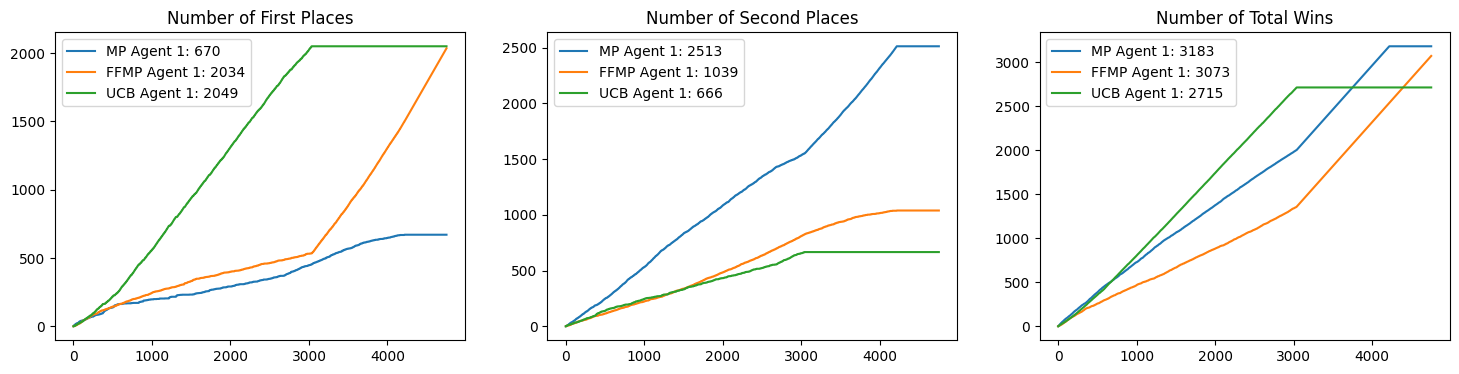

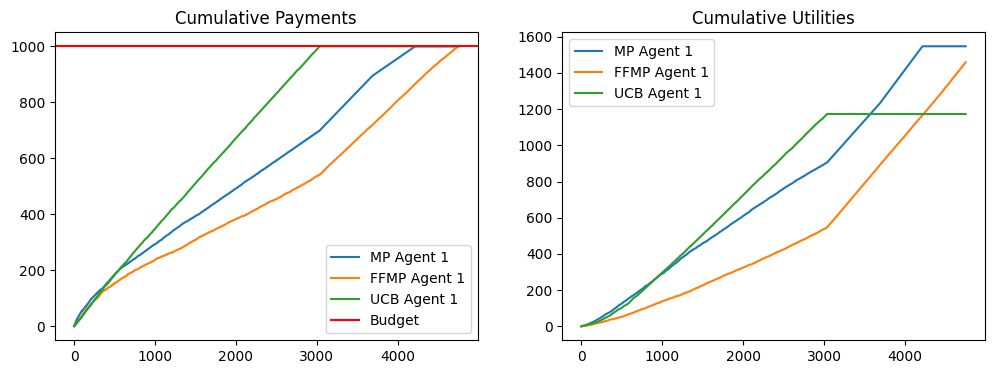

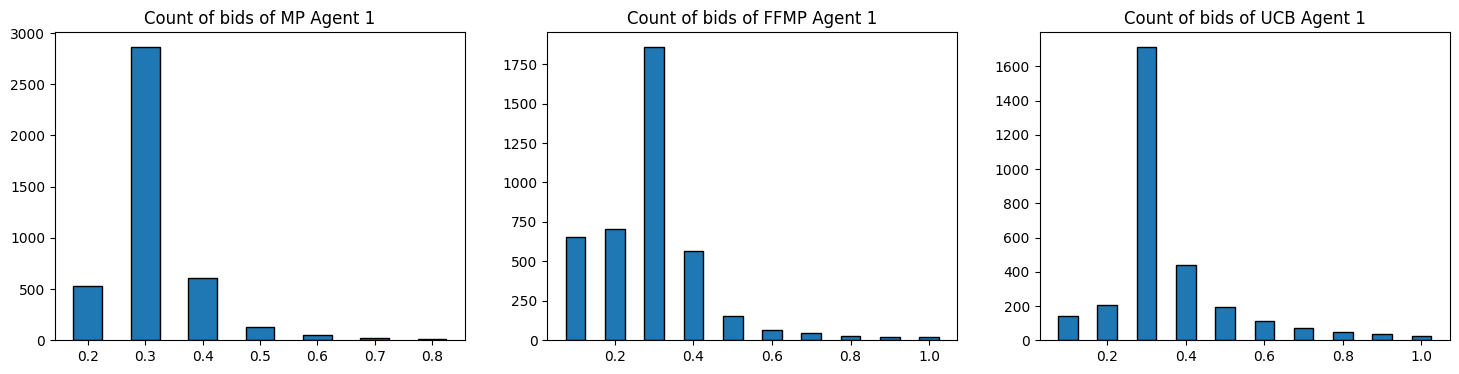

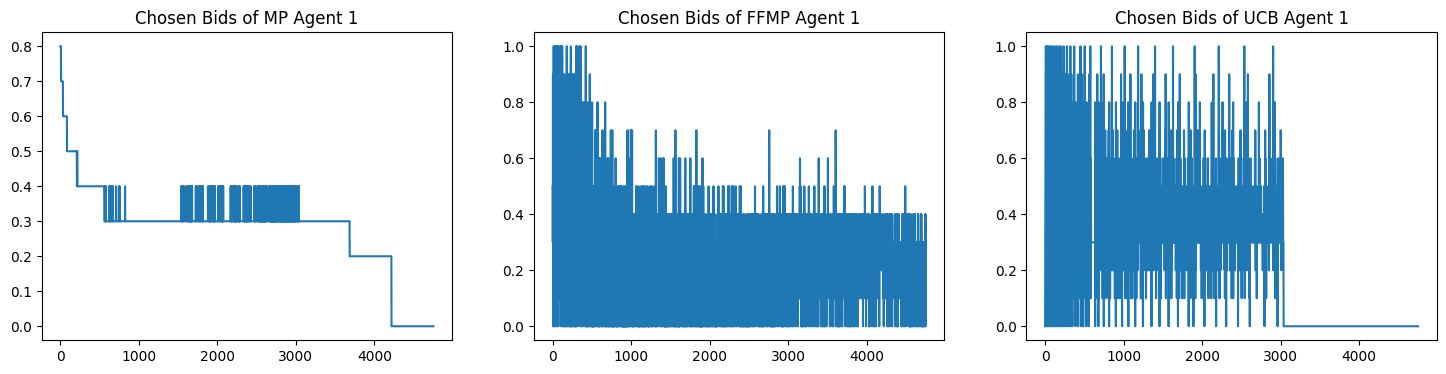

In [19]:
trial = Trial()
trial.plot_winnings()
trial.plot_payments_and_utilities()
trial.plot_biddings()

### Increase competition i.e. n_player_per_type (and also n_users)

*   n_player_per_type = **3**
*   my_evaluation = [0.8, 0.8]
*   B = 1000
*   n_users = **15000**
*   n_arms = 11


Total # of interactions: 10680


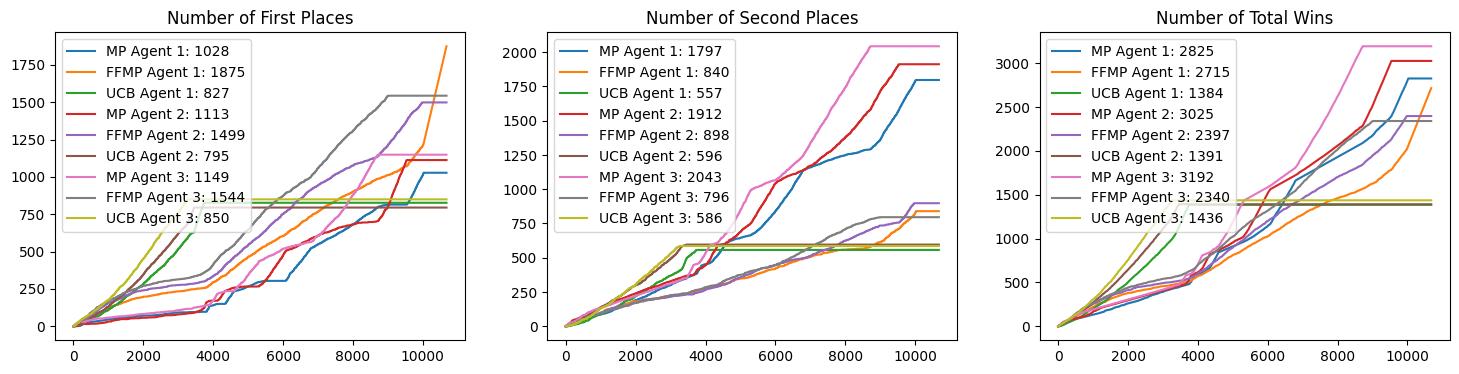

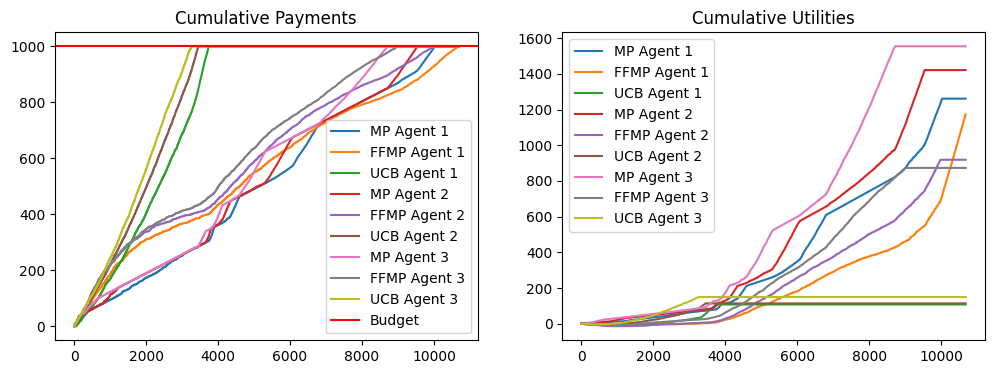

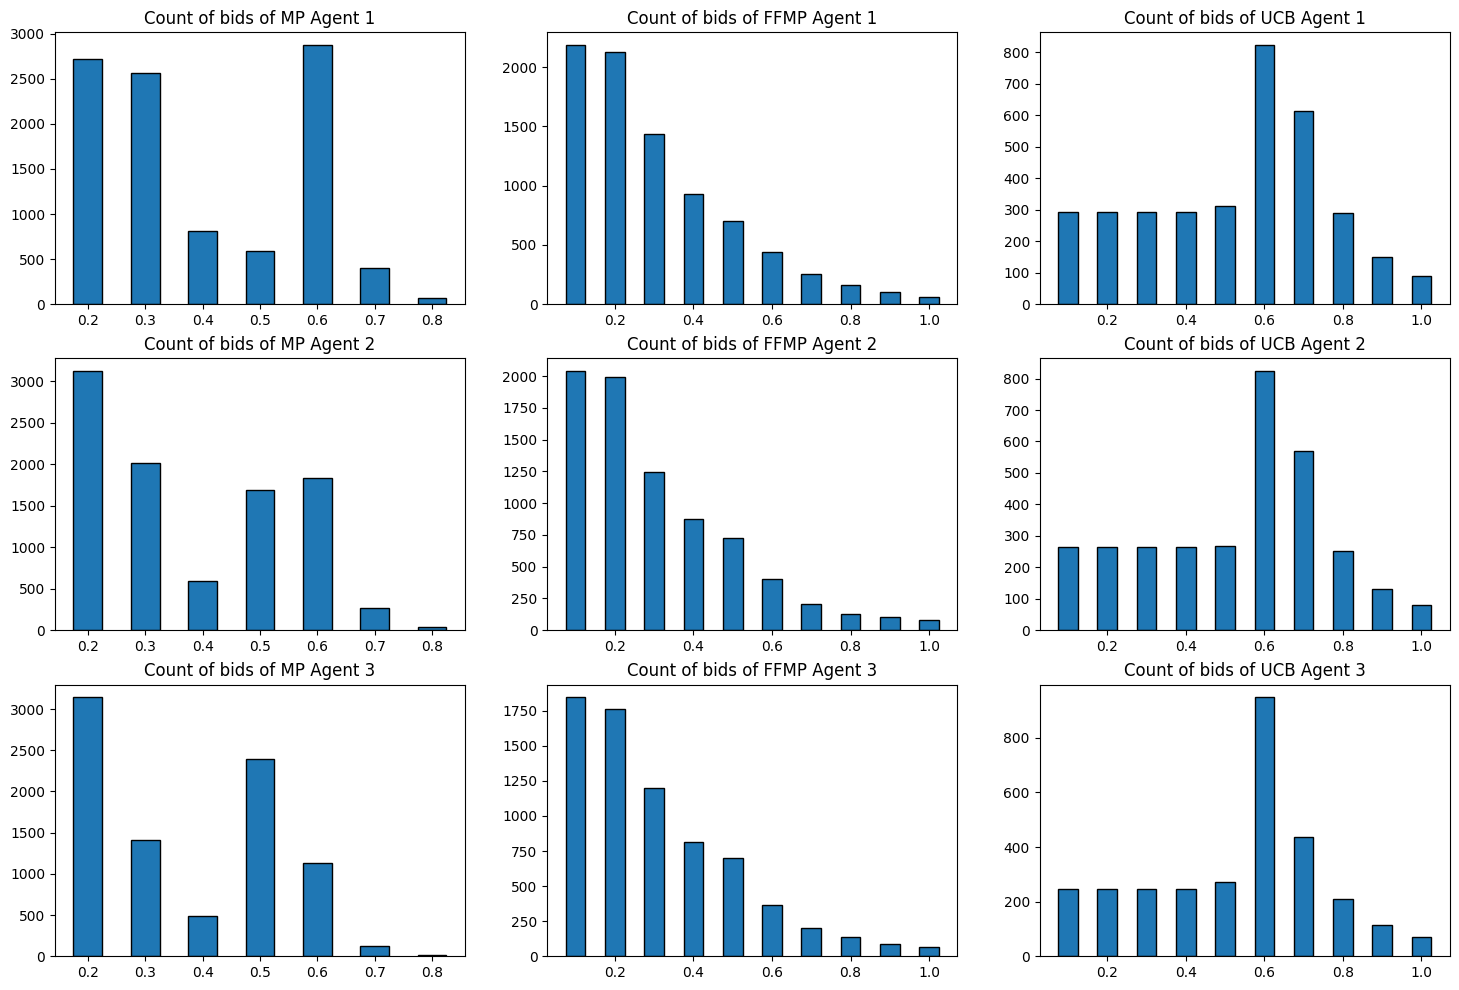

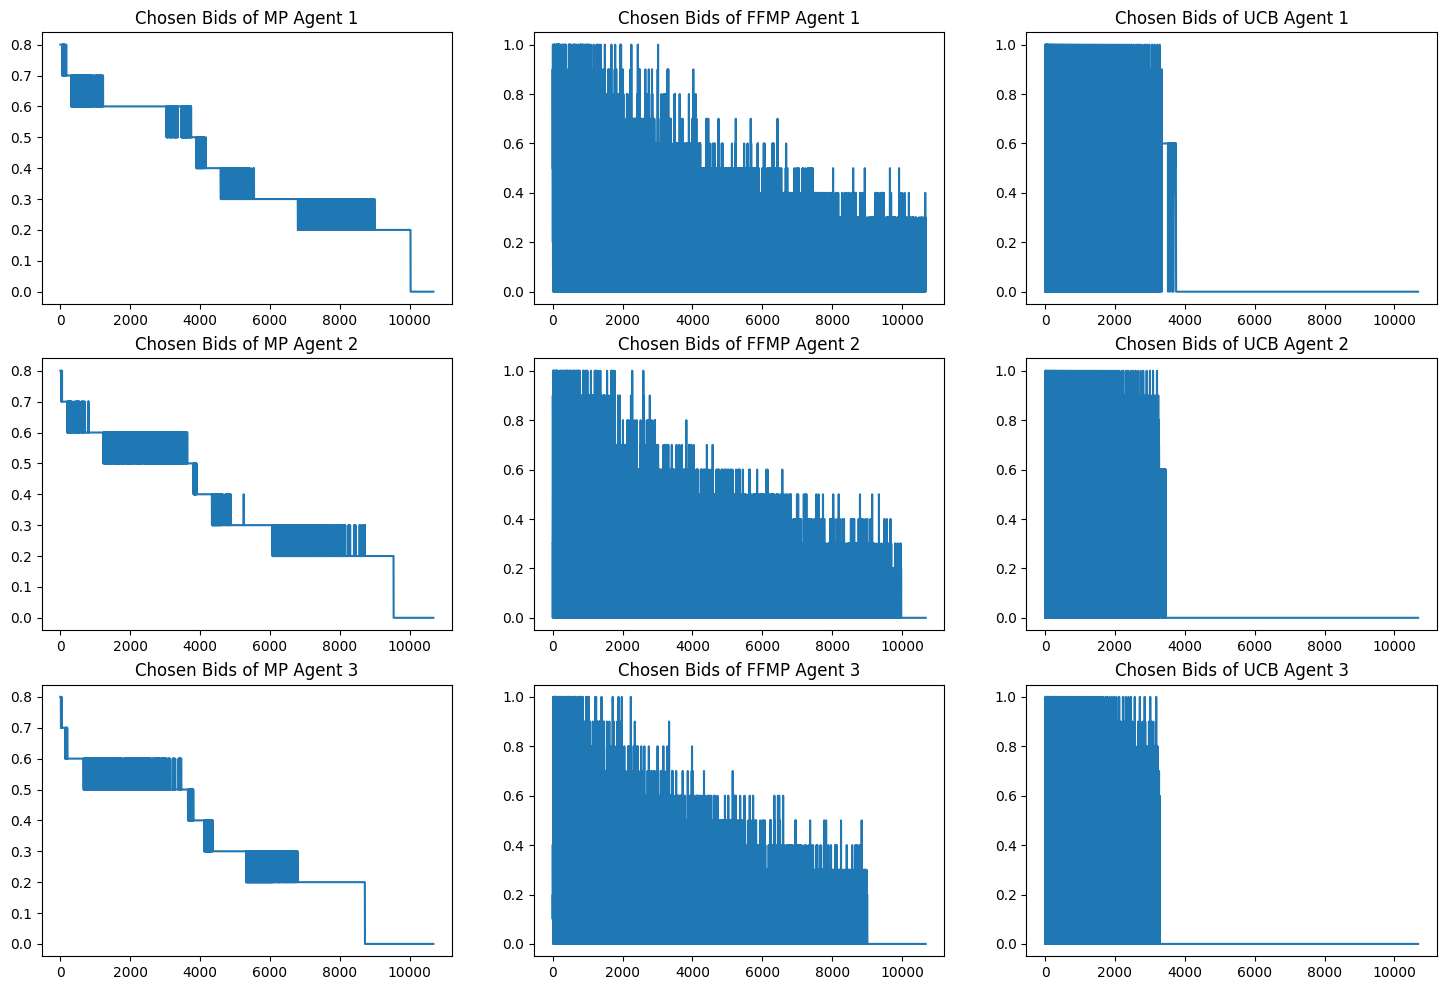

In [20]:
trial = Trial(n_player_per_type=3, my_valuations=[0.8, 0.8], B=1000, n_users=15000, n_arms=11)
trial.plot_winnings()
trial.plot_payments_and_utilities()
trial.plot_biddings()

### Add more arms

*   n_player_per_type = 3
*   my_evaluation = [0.8, 0.8]
*   B = 1000
*   n_users = 15000
*   n_arms = **21**

Total # of interactions: 10494


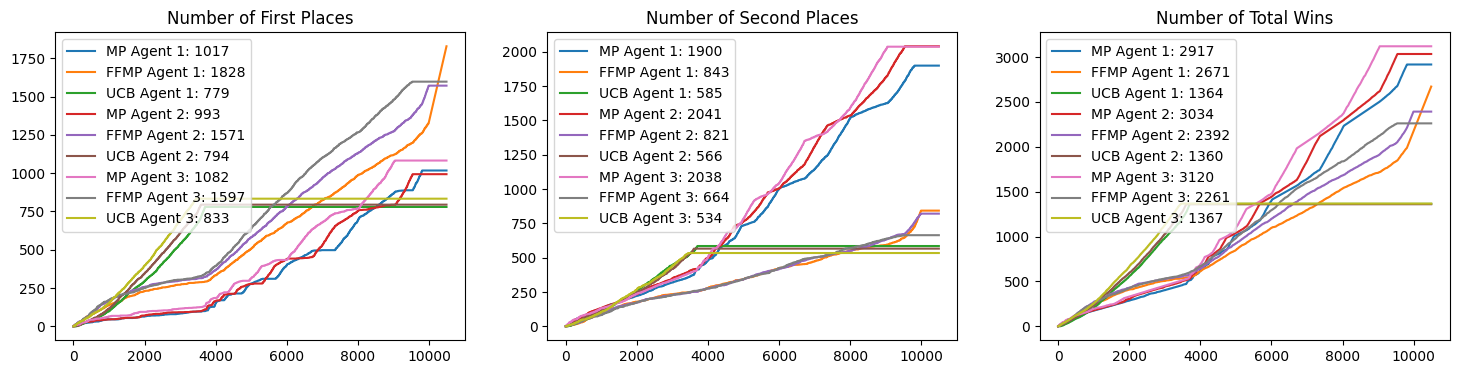

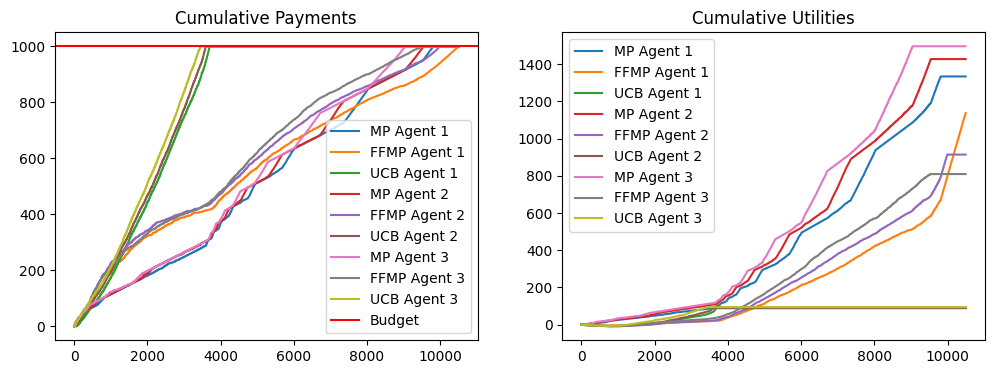

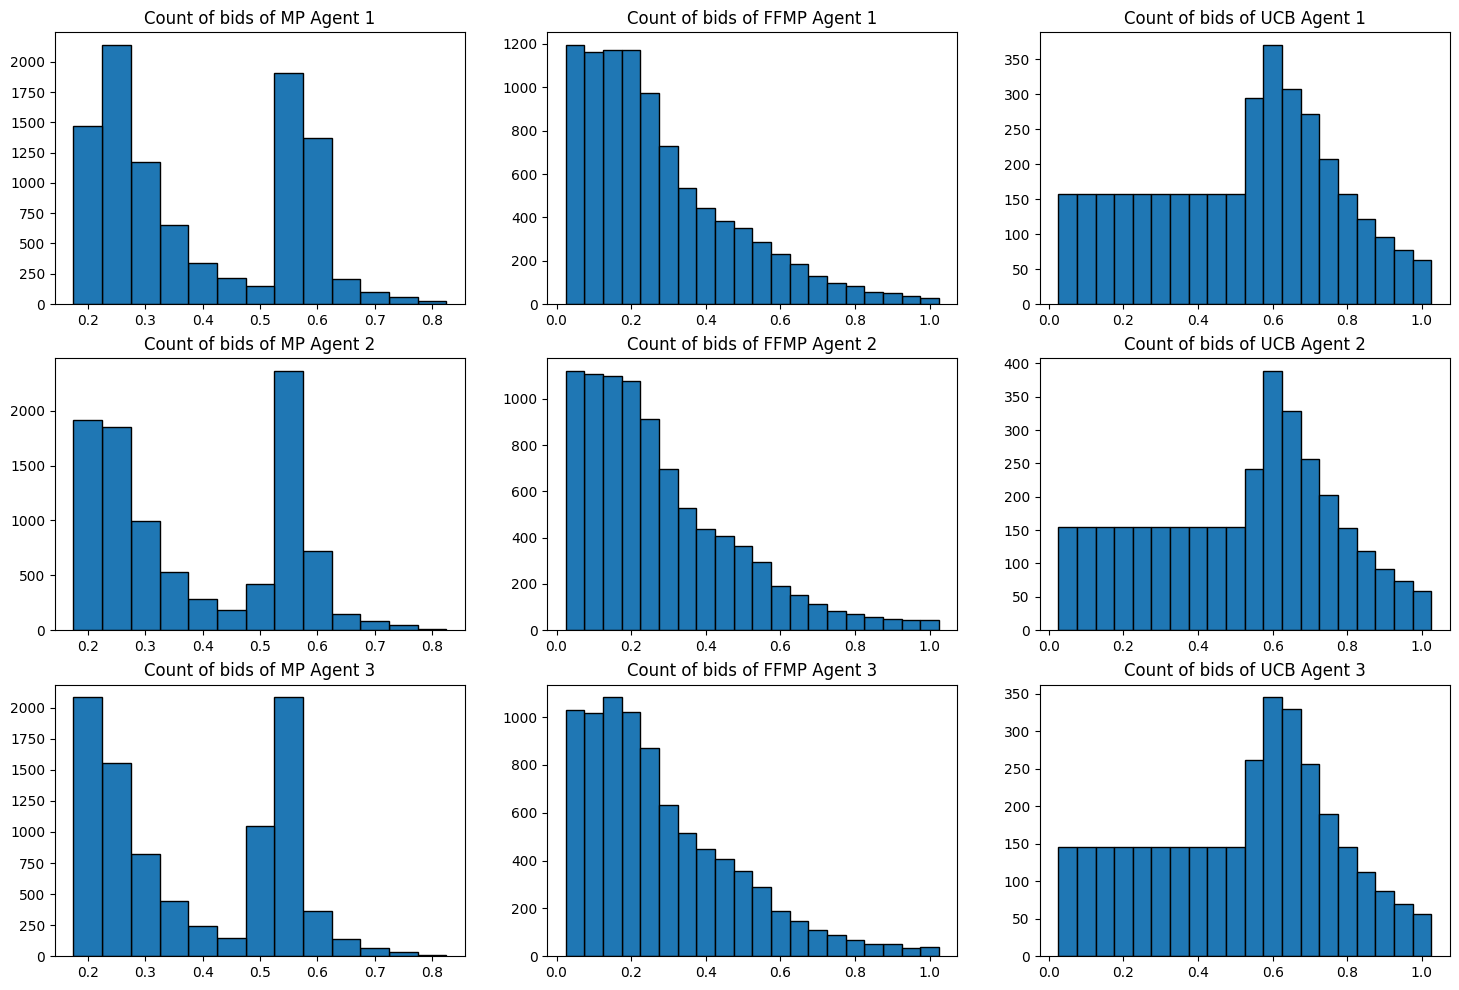

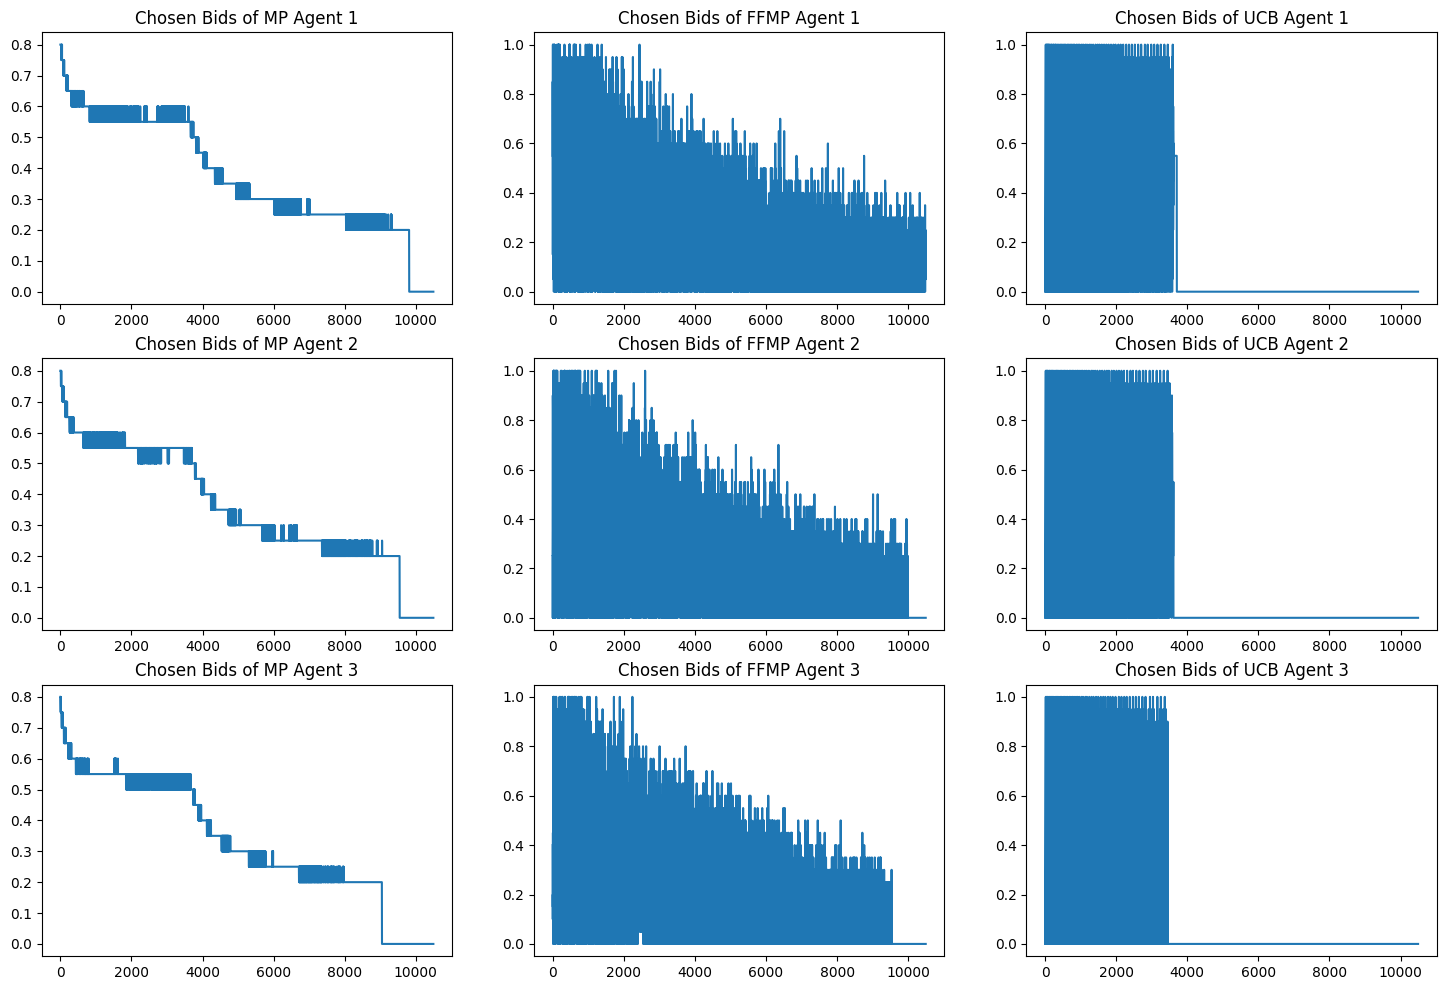

In [21]:
trial = Trial(n_player_per_type=3, my_valuations=[0.8, 0.8], B=1000, n_users=15000, n_arms=21)
trial.plot_winnings()
trial.plot_payments_and_utilities()
trial.plot_biddings()

## Another scenario: the second slot has a lower valuation

*   n_player_per_type = 1
*   my_evaluation = **[0.8, 0.4]**
*   B = 1000
*   n_users = 5000
*   n_arms = 11

Total # of interactions: 4748


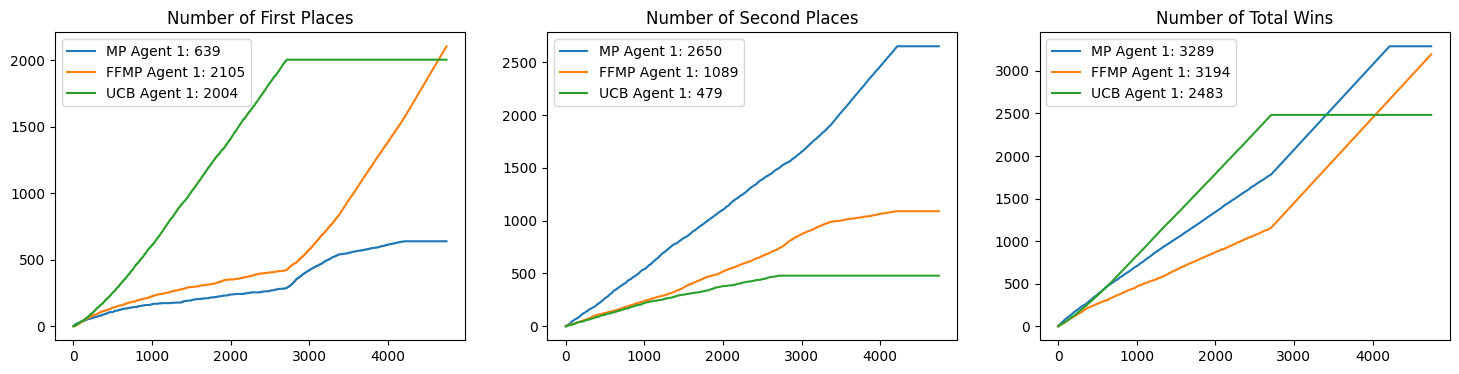

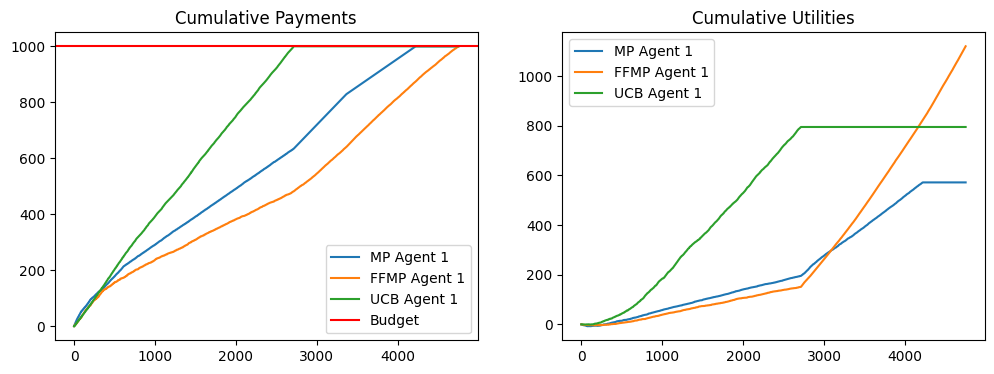

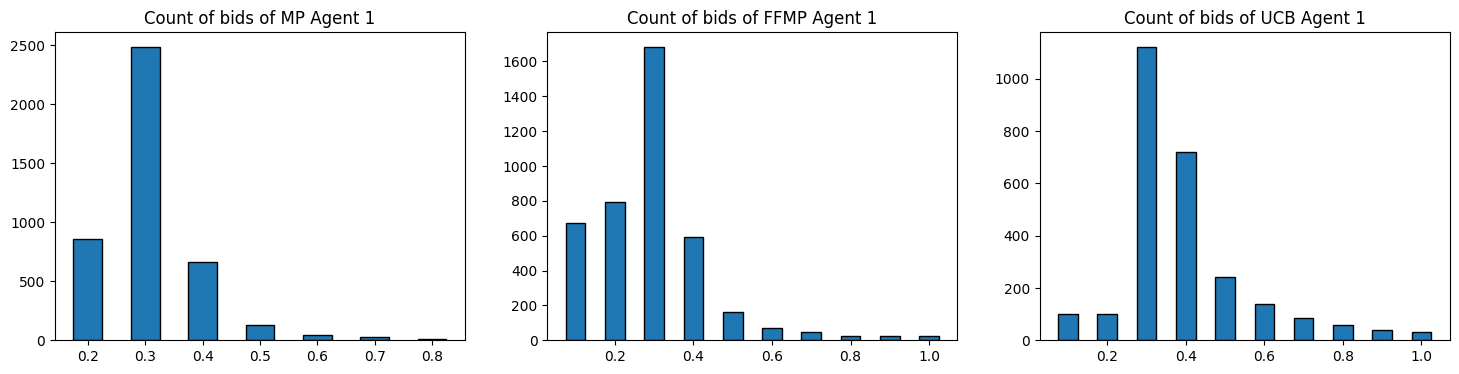

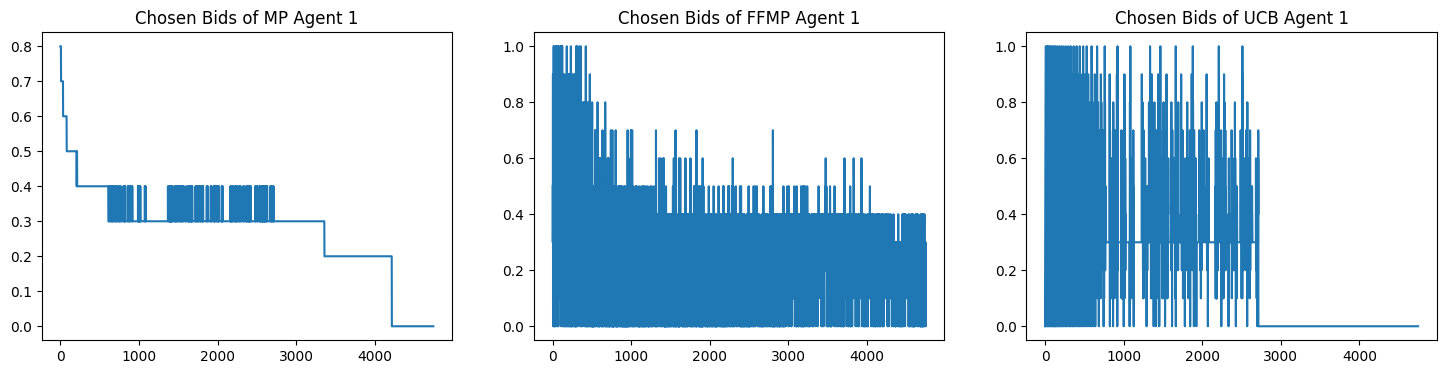

In [22]:
trial = Trial(n_player_per_type=1, my_valuations=[0.8, 0.4], B=1000, n_users=5000, n_arms=11)
trial.plot_winnings()
trial.plot_payments_and_utilities()
trial.plot_biddings()

### Increase competition (and also n_users)

*   n_player_per_type = **3**
*   my_evaluation = [0.8, 0.4]
*   B = 1000
*   n_users = **15000**
*   n_arms = 11

Total # of interactions: 10699


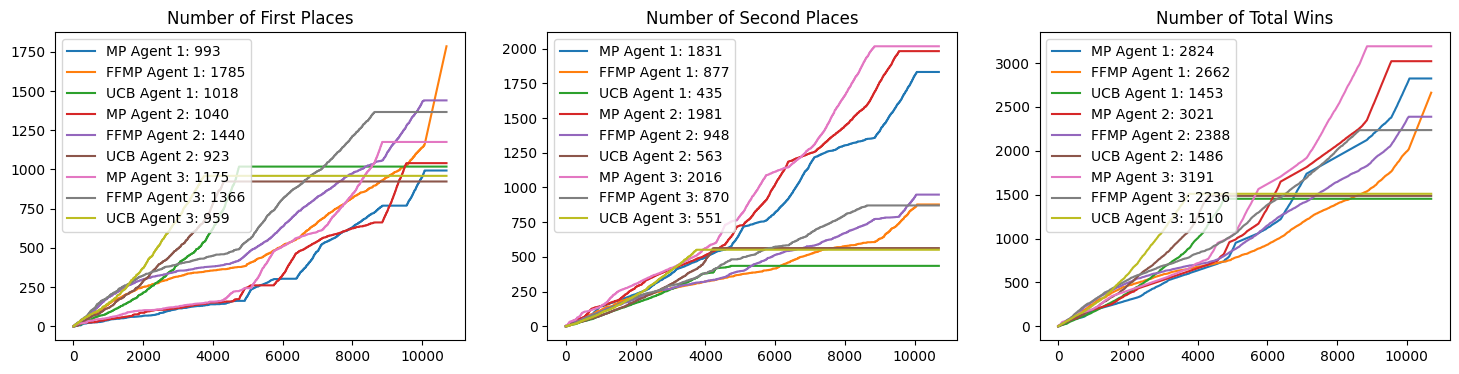

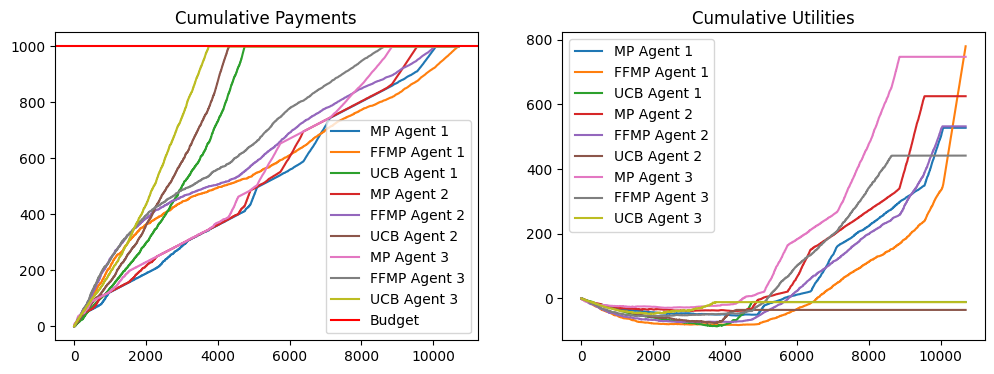

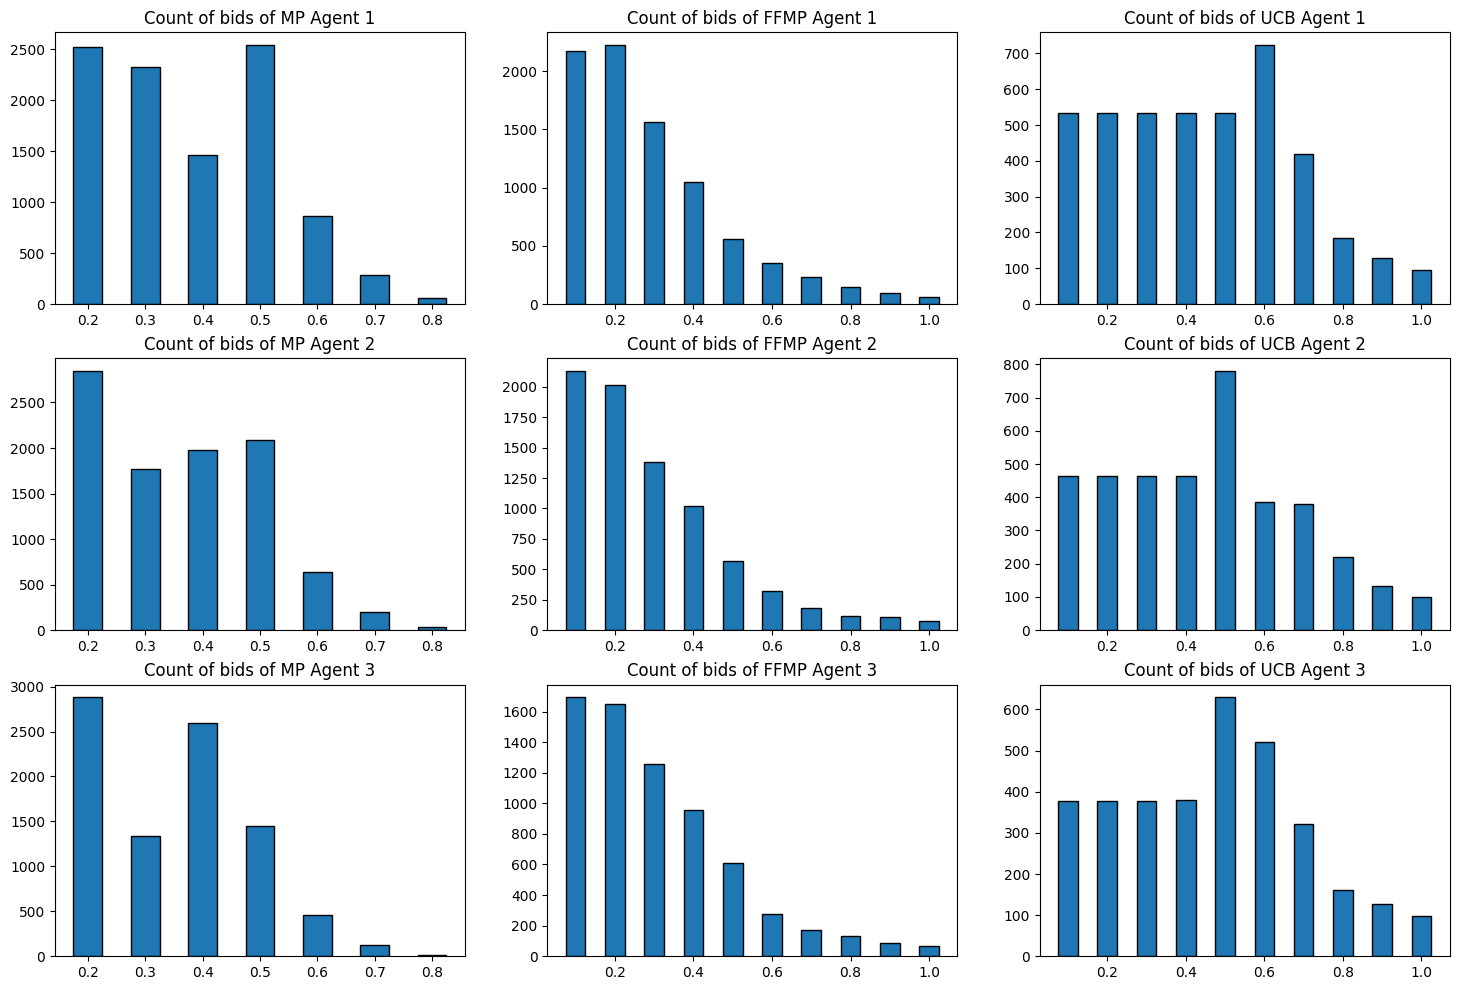

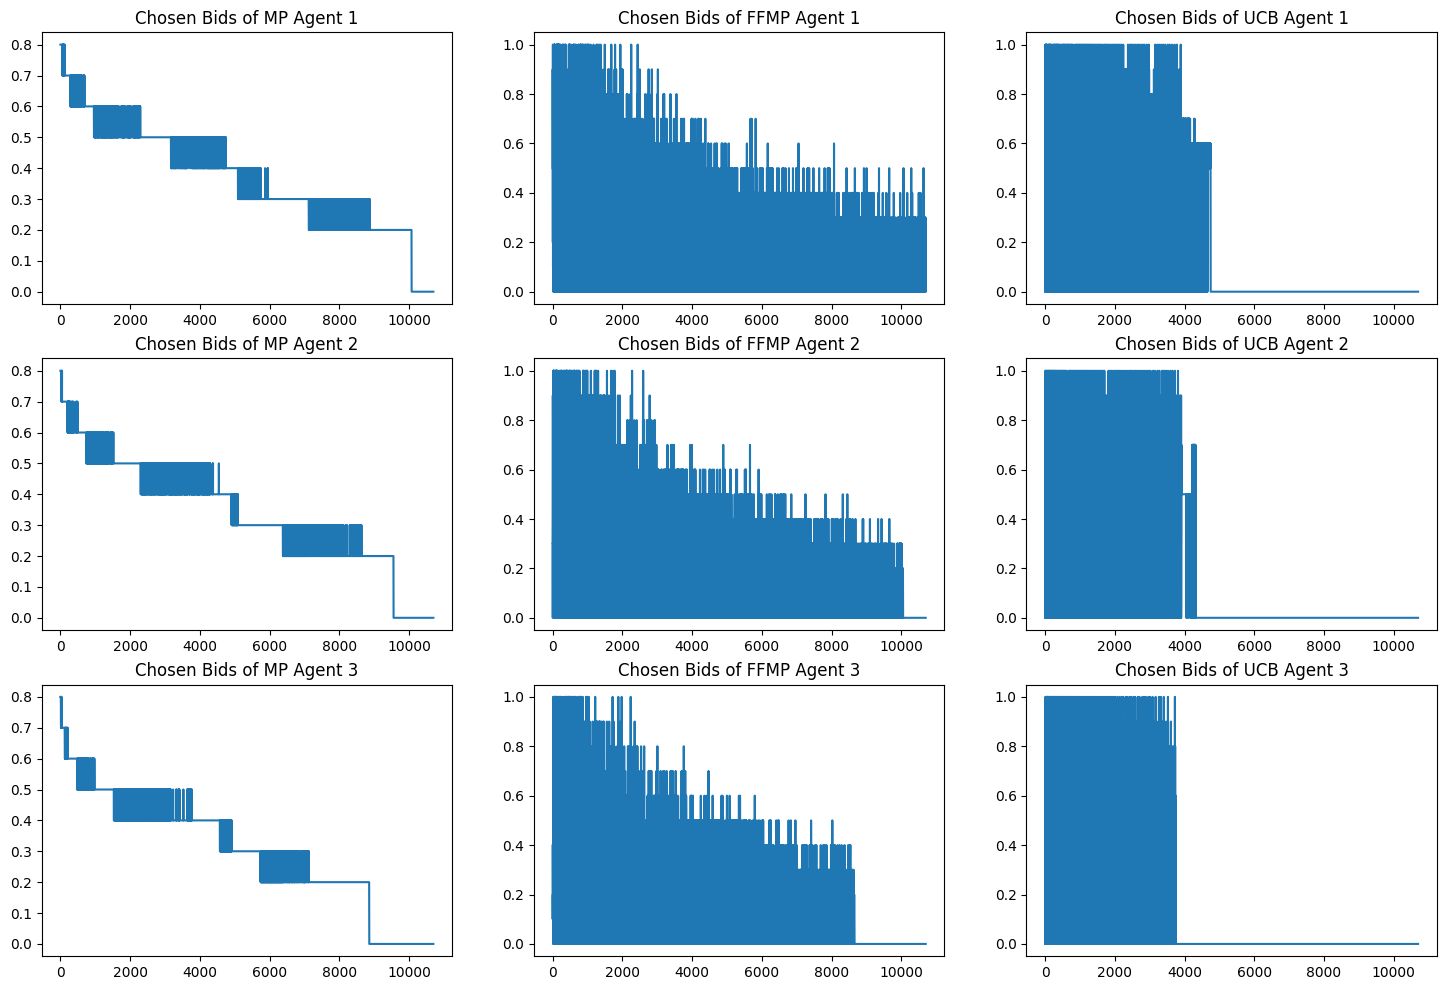

In [23]:
trial = Trial(n_player_per_type=3, my_valuations=[0.8, 0.4], B=1000, n_users=15000, n_arms=11)
trial.plot_winnings()
trial.plot_payments_and_utilities()
trial.plot_biddings()

### Add more arms

*   n_player_per_type = 3
*   my_evaluation = [0.8, 0.4]
*   B = 1000
*   n_users = 15000
*   n_arms = **21**

Total # of interactions: 10449


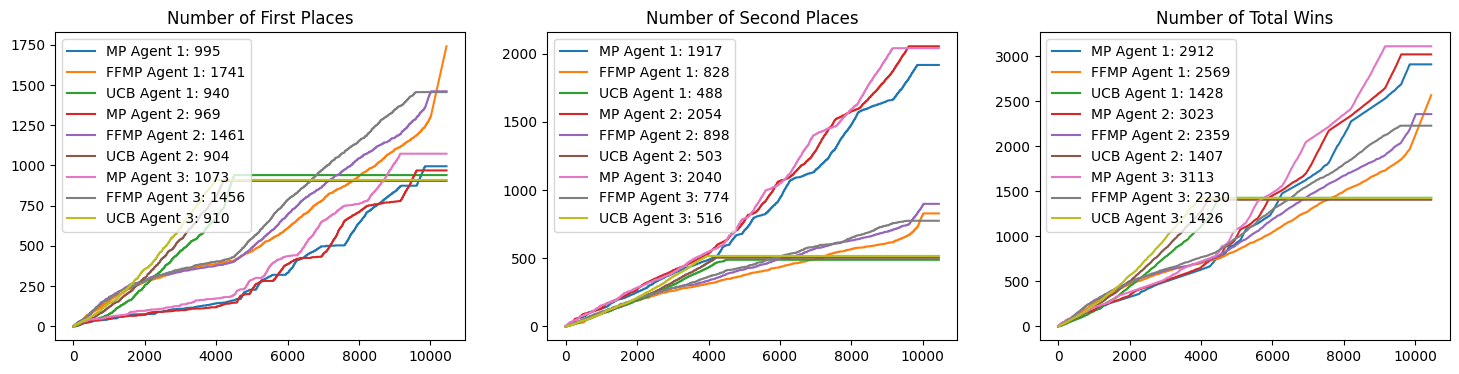

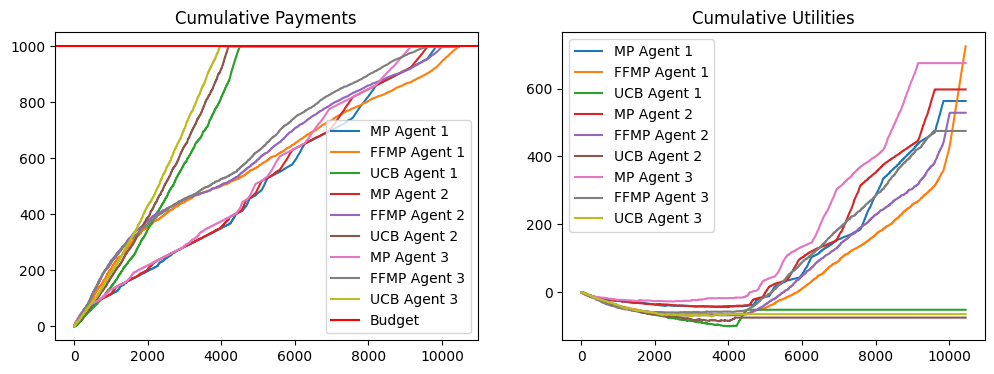

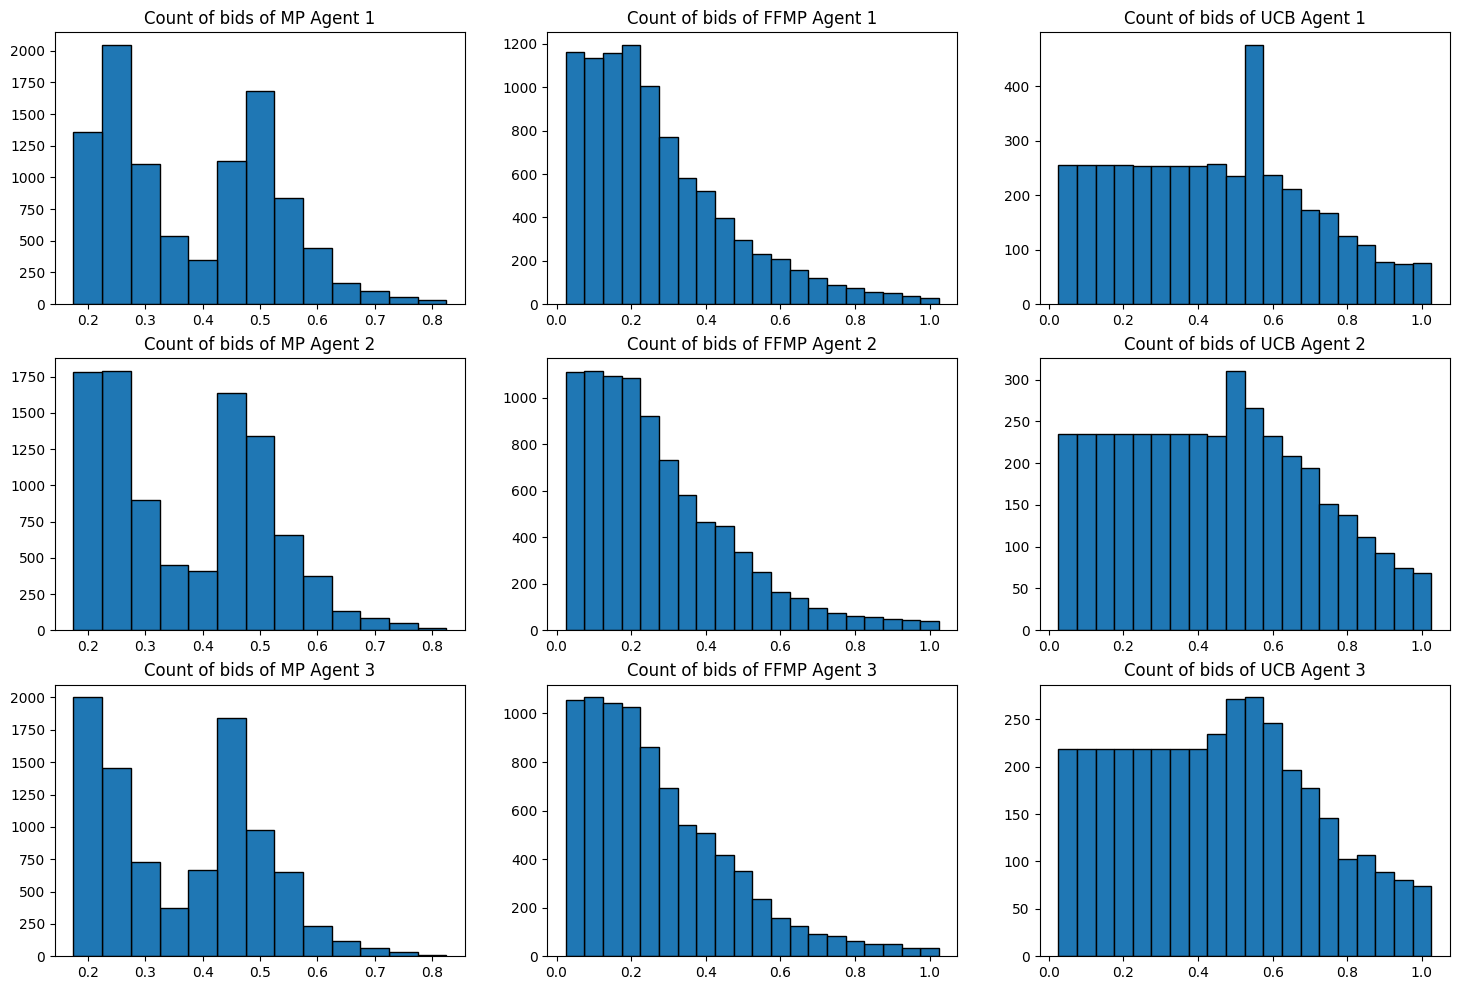

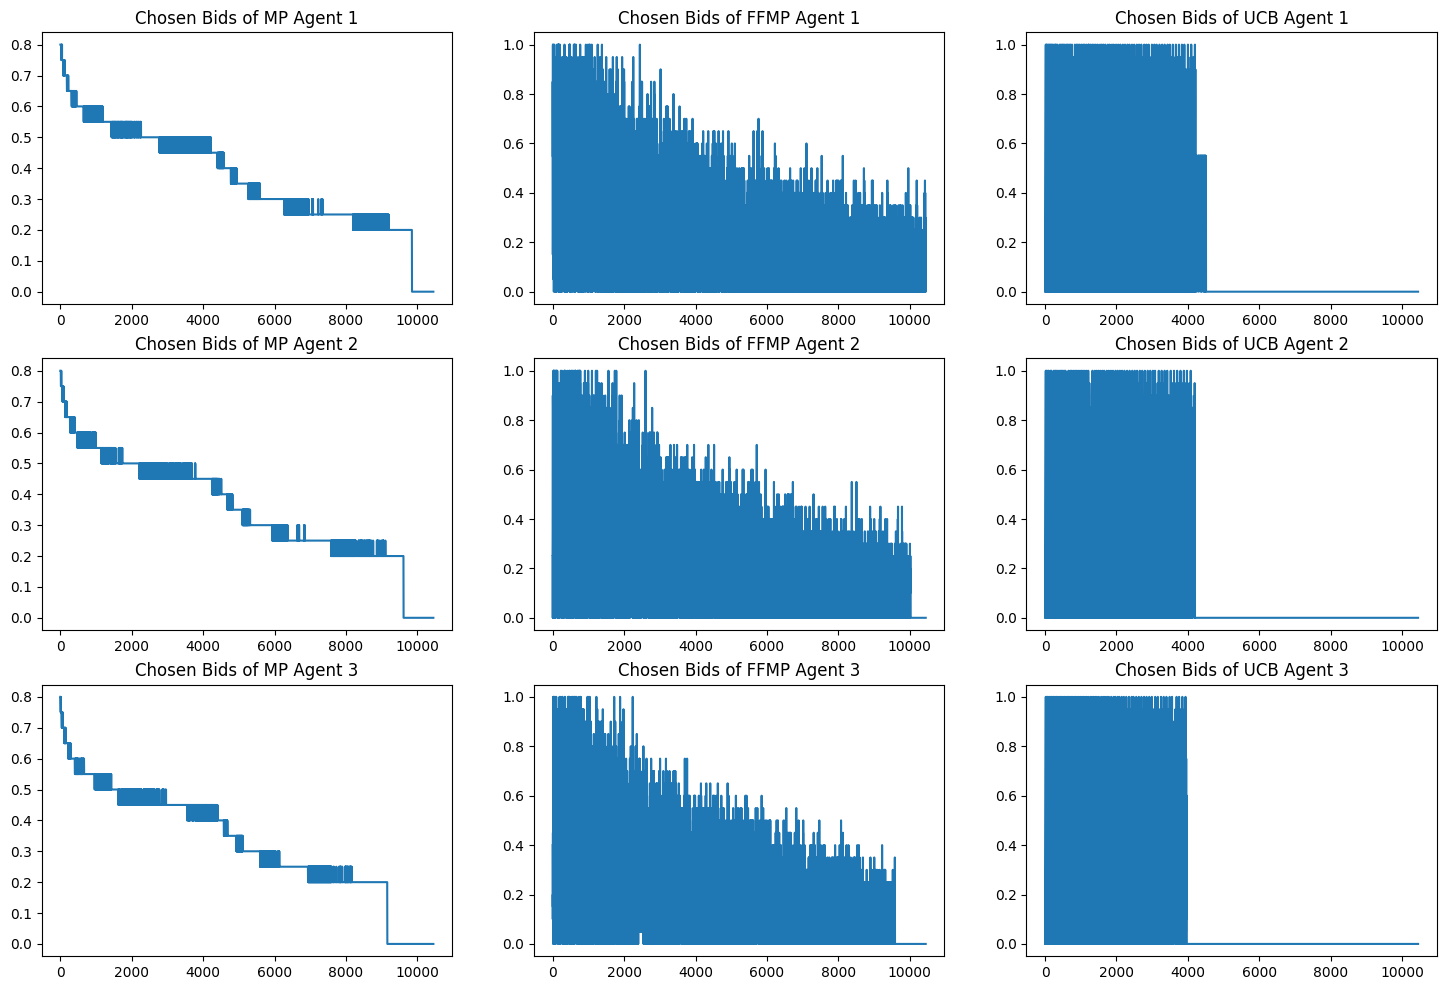

In [24]:
trial = Trial(n_player_per_type=3, my_valuations=[0.8, 0.4], B=1000, n_users=15000, n_arms=21)
trial.plot_winnings()
trial.plot_payments_and_utilities()
trial.plot_biddings()